In [ ]:
import math
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from datetime import datetime
import time
from sklearn.inspection import permutation_importance

plt.style.use('classic')
%matplotlib inline
sns.set()

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Functions

In [ ]:
def tweets_cleaner(text):

    text = ' '.join(text.split('.'))
    text = re.sub('\/',' ',text)
    text = text.strip('\'"')
    text = re.sub(r'@([^\s]+)',r'\1',text)
    text = re.sub(r'\\',' ',text)
    text = text.lower()
    text = re.sub('[\s]+', ' ', text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
    text = re.sub(r'((http)\S+)','',text)
    text = re.sub(r'\s+', ' ', re.sub('[^A-Za-z]', ' ', text.strip().lower())).strip()
    text = re.sub(r'\W+', ' ', text.strip().lower()).strip()

    return text

In [ ]:
def test_binary_clf(clf, X_test, y_test):
    
    y_pred = clf.predict(X_test)
    
    print('Accuracy: %s' % accuracy_score(y_test, y_pred), end='\n\n')
    print('F1-score: %s' % f1_score(y_test, y_pred, average=None), end='\n\n')
    print('Weighted Average F1-score: %s' % f1_score(y_test, y_pred, average='weighted'), end='\n\n')
    print(classification_report(y_test, y_pred), end='\n\n')

    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues', fmt = '', xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    plt.show()
    
    print("\n")

    y_score = clf.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label='$AUC$ = %.3f' % (roc_auc))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=14, frameon=False)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.show()

    return y_pred


def feature_importance(estimator, X_train, y_train):

    nbr_features = X_train.shape[1]

    try:
        tree_feature_importances = estimator.feature_importances_
        sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

        plt.barh(range(nbr_features), tree_feature_importances[sorted_idx])
        plt.yticks(range(nbr_features), X_train.columns[sorted_idx])
        plt.title("Feature Importances on Training Set")
        plt.show()

    except:
        perm_importance = permutation_importance(estimator, X_train, y_train, n_repeats=10, random_state=100, n_jobs=2)

        sorted_idx = perm_importance.importances_mean.argsort()[-nbr_features:]

        plt.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
        plt.title("Permutation Importances on Training Set")
        plt.tight_layout()
        plt.show()


def test_reg(reg, X_test, y_test):

    y_pred = reg.predict(X_test)
    
    print('R2: %.3f' % r2_score(y_test, y_pred))
    print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
    print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))
    print('RMSE: %.3f' % math.sqrt(mean_squared_error(y_test, y_pred)))

    return y_pred

# Dataset

In [ ]:
df_predictions_2019 = pd.read_csv("/gdrive/My Drive/TextAnalytics/datasets/df_predictions_2019.csv")

df_predictions_2019['date'] = pd.to_datetime(df_predictions_2019['date'])
df_predictions_2019 = df_predictions_2019.set_index(['date']).sort_index()

df_predictions_2019

,tweets_volume,median_polarity,vader_sentiment_mode,transformers_sentiment_mode,topic_mode,close,returns,up_down,volatility,up_down_next2min,returns_next2min,volatility_next2min
date,,,,,,,,,,,,
2019-05-06 05:29:00,1,0.86250,1,1,"BITCOIN, price, time, block, transactions, siz...",5657.66,0.017500,1,0.113277,-1.0,-0.033911,0.067637
2019-05-06 07:26:00,2,0.75005,1,1,"blockchain, crypto, great, good, project, team...",5599.59,-0.144014,-1,0.067993,1.0,0.051701,0.073179
2019-05-06 07:39:00,1,0.72690,1,1,"money, BITCOIN, news, love, trading, business,...",5601.97,-0.033911,-1,0.067637,-1.0,-0.040469,0.072450
2019-05-06 08:31:00,2,0.82890,1,1,"people, market, shit, bsv, bad, hard, years, g...",5610.62,0.051701,1,0.073179,-1.0,-0.000713,0.072788
2019-05-06 08:48:00,1,0.84420,1,1,"BITCOIN, crypto, free, buy, profit, link, aird...",5608.12,-0.040469,-1,0.072450,-1.0,-0.044076,0.073415
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-26 23:48:00,5,-0.38180,0,0,"ETHEREUM, BINANCE, XRP, st, BITCOIN, win, lite...",8089.50,-0.187968,-1,0.124144,1.0,0.010269,0.121960
2019-09-26 23:49:00,5,-0.51060,0,0,"long, back, alts, short, dump, high, support, ...",8082.16,-0.090776,-1,0.122946,-1.0,-0.134075,0.122263
2019-09-26 23:50:00,1,-0.51060,0,0,"money, BITCOIN, news, love, trading, business,...",8082.99,0.010269,1,0.121960,1.0,0.034482,0.122251


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df_predictions_2019["topic_mode"])

le.classes_

array(['BITCOIN, crypto, free, buy, profit, link, airdrop, join, sell, future',
       'BITCOIN, gt, volume, market, usd, free, ETHEREUM, days, check, week',
       'BITCOIN, make, trade, mining, free, today, trading, invest, account, investment',
       'BITCOIN, price, time, block, transactions, size, miner, supply, total, number',
       'BITCOIN, scam, read, million, ban, man, futures, fraud, exchanges, fake',
       'ETHEREUM, BINANCE, XRP, st, BITCOIN, win, litecoin, ripple, bch, trx',
       'blockchain, crypto, great, good, project, team, ico, ETHEREUM, tokensale, lt',
       'crypto, BITCOIN, AMP, ETHEREUM, blockchain, exchange, earn, bonus, airdrop, top',
       'long, back, alts, short, dump, high, support, run, low, move',
       'money, BITCOIN, news, love, trading, business, crypto, forex, investing, twitter',
       'people, gold, libra, fiat, network, work, apompliano, system, facebook, real',
       'people, market, shit, bsv, bad, hard, years, give, current, lol'],
  

In [ ]:
df_predictions_2019["topic_mode"] = le.transform(df_predictions_2019["topic_mode"])
df_predictions_2019

,tweets_volume,median_polarity,vader_sentiment_mode,transformers_sentiment_mode,topic_mode,close,returns,up_down,volatility,up_down_next2min,returns_next2min,volatility_next2min
date,,,,,,,,,,,,
2019-05-06 05:29:00,1,0.86250,1,1,3,5657.66,0.017500,1,0.113277,-1.0,-0.033911,0.067637
2019-05-06 07:26:00,2,0.75005,1,1,6,5599.59,-0.144014,-1,0.067993,1.0,0.051701,0.073179
2019-05-06 07:39:00,1,0.72690,1,1,9,5601.97,-0.033911,-1,0.067637,-1.0,-0.040469,0.072450
2019-05-06 08:31:00,2,0.82890,1,1,11,5610.62,0.051701,1,0.073179,-1.0,-0.000713,0.072788
2019-05-06 08:48:00,1,0.84420,1,1,0,5608.12,-0.040469,-1,0.072450,-1.0,-0.044076,0.073415
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-26 23:48:00,5,-0.38180,0,0,5,8089.50,-0.187968,-1,0.124144,1.0,0.010269,0.121960
2019-09-26 23:49:00,5,-0.51060,0,0,8,8082.16,-0.090776,-1,0.122946,-1.0,-0.134075,0.122263
2019-09-26 23:50:00,1,-0.51060,0,0,9,8082.99,0.010269,1,0.121960,1.0,0.034482,0.122251


In [ ]:
le.inverse_transform(df_predictions_2019["topic_mode"])

array(['BITCOIN, price, time, block, transactions, size, miner, supply, total, number',
       'blockchain, crypto, great, good, project, team, ico, ETHEREUM, tokensale, lt',
       'money, BITCOIN, news, love, trading, business, crypto, forex, investing, twitter',
       ...,
       'money, BITCOIN, news, love, trading, business, crypto, forex, investing, twitter',
       'BITCOIN, scam, read, million, ban, man, futures, fraud, exchanges, fake',
       'people, gold, libra, fiat, network, work, apompliano, system, facebook, real'],
      dtype=object)

# Up_Down_next2min Prediction

In [ ]:
import pickle

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

## Train Test Split

In [ ]:
train_test_split_date = "2019-09-05 00:00:00"
X_cols = ["tweets_volume", "median_polarity", "vader_sentiment_mode", "transformers_sentiment_mode", "topic_mode", "returns", "volatility", "up_down"]
y_col = "up_down_next2min"

X_train = df_predictions_2019[X_cols].loc[df_predictions_2019.index < train_test_split_date].copy()
y_train = df_predictions_2019[y_col].loc[df_predictions_2019.index < train_test_split_date].copy()
X_test = df_predictions_2019[X_cols].loc[df_predictions_2019.index >= train_test_split_date].copy()
y_test = df_predictions_2019[y_col].loc[df_predictions_2019.index >= train_test_split_date].copy()

In [ ]:
X_train

,tweets_volume,median_polarity,vader_sentiment_mode,transformers_sentiment_mode,topic_mode,returns,volatility,up_down
date,,,,,,,,
2019-05-06 05:29:00,1,0.86250,1,1,3,0.017500,0.113277,1
2019-05-06 07:26:00,2,0.75005,1,1,6,-0.144014,0.067993,-1
2019-05-06 07:39:00,1,0.72690,1,1,9,-0.033911,0.067637,-1
2019-05-06 08:31:00,2,0.82890,1,1,11,0.051701,0.073179,1
2019-05-06 08:48:00,1,0.84420,1,1,0,-0.040469,0.072450,-1
...,...,...,...,...,...,...,...,...
2019-09-04 23:53:00,1,0.70030,1,1,2,0.163584,0.128238,1
2019-09-04 23:54:00,5,0.76500,1,1,2,-0.146307,0.128577,-1
2019-09-04 23:56:00,3,0.70030,1,1,2,-0.016805,0.128381,-1


In [ ]:
y_train.value_counts(normalize=True)

 1.0    0.505154
-1.0    0.494846
Name: up_down_next2min, dtype: float64

In [ ]:
X_test

,tweets_volume,median_polarity,vader_sentiment_mode,transformers_sentiment_mode,topic_mode,returns,volatility,up_down
date,,,,,,,,
2019-09-05 00:00:00,3,0.7783,1,1,11,0.025502,0.128536,1
2019-09-05 00:02:00,4,-0.4643,0,0,8,-0.215456,0.129148,-1
2019-09-05 00:03:00,1,-0.3612,0,1,3,-0.075268,0.129094,-1
2019-09-05 00:04:00,3,-0.3400,0,1,2,-0.117418,0.129310,-1
2019-09-05 00:07:00,1,-0.3182,0,0,11,-0.004549,0.129342,-1
...,...,...,...,...,...,...,...,...
2019-09-26 23:48:00,5,-0.3818,0,0,5,-0.187968,0.124144,-1
2019-09-26 23:49:00,5,-0.5106,0,0,8,-0.090776,0.122946,-1
2019-09-26 23:50:00,1,-0.5106,0,0,9,0.010269,0.121960,1


In [ ]:
y_test.value_counts(normalize=True)

 1.0    0.508475
-1.0    0.491525
Name: up_down_next2min, dtype: float64

### Random Forest

In [ ]:
pipeline = Pipeline([
                     ('scaler', StandardScaler()),
                     #('pca', PCA()),
                     ('clf', RandomForestClassifier())  # learning classifier
                     ])

In [ ]:
r_param_grid = [
                #{'pca__n_components': list(range(4,8))},
                {'clf__max_depth': list(range(5, 15))}
                ]


optr_search = RandomizedSearchCV(pipeline, r_param_grid, cv=5, n_iter=5, n_jobs=4, verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  2.8min finished


In [ ]:
optr_search.best_params_

{'clf__max_depth': 12}

In [ ]:
optr_search.cv_results_

{'mean_fit_time': array([17.49481039, 33.65660281, 21.87983551, 26.45231066, 24.24780993]),
 'mean_score_time': array([0.47577333, 0.68959246, 0.52798252, 0.59001875, 0.47933507]),
 'mean_test_score': array([0.49383737, 0.49665729, 0.49452835, 0.49635849, 0.4950326 ]),
 'param_clf__max_depth': masked_array(data=[5, 12, 7, 9, 10],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__max_depth': 5},
  {'clf__max_depth': 12},
  {'clf__max_depth': 7},
  {'clf__max_depth': 9},
  {'clf__max_depth': 10}],
 'rank_test_score': array([5, 1, 4, 2, 3], dtype=int32),
 'split0_test_score': array([0.49323063, 0.49607843, 0.49281046, 0.49407096, 0.4907563 ]),
 'split1_test_score': array([0.49183007, 0.49579832, 0.49822596, 0.49971989, 0.50056022]),
 'split2_test_score': array([0.50219421, 0.49561158, 0.49565826, 0.49369748, 0.49243697]),
 'split3_test_score': array([0.48302909, 0.49600822, 0.4863439 , 0.49390728, 0.48947196]),
 

In [ ]:
best_pipe = optr_search.best_estimator_

In [ ]:
best_pipe

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=12, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [ ]:
best_pipe.predict(X_test)

array([ 1.,  1., -1., ...,  1.,  1.,  1.])

In [ ]:
with open('/gdrive/My Drive/TextAnalytics/models/fitted_randomForest', 'wb') as f:
    pickle.dump(best_pipe, f)

"\nwith open('/gdrive/My Drive/TextAnalytics/models/fitted_randomForest', 'wb') as f:\n    pickle.dump(best_pipe, f)\n"

In [ ]:
"""
with open("/gdrive/My Drive/TextAnalytics/models/fitted_randomForest", 'rb') as f:
    best_pipe = pickle.load(f)
"""

'\nwith open("/gdrive/My Drive/TextAnalytics/models/fitted_randomForest", \'rb\') as f:\n    best_pipe = pickle.load(f)\n'

Accuracy: 0.5091104489277515

F1-score: [0.41237355 0.57849922]

Weighted Average F1-score: 0.49684436699561213

              precision    recall  f1-score   support

        -1.0       0.50      0.35      0.41     10062
         1.0       0.51      0.66      0.58     10409

    accuracy                           0.51     20471
   macro avg       0.51      0.51      0.50     20471
weighted avg       0.51      0.51      0.50     20471




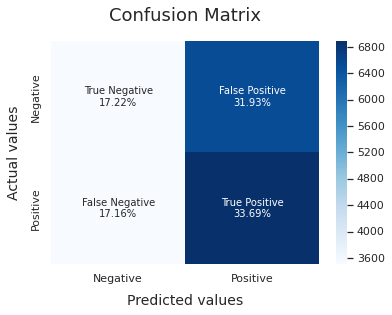

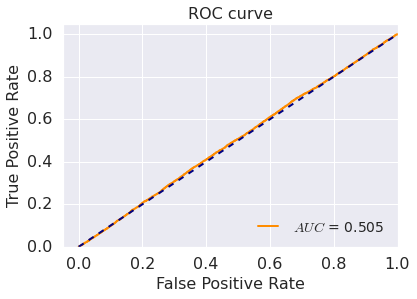

In [ ]:
y_pred = test_binary_clf(best_pipe, X_test, y_test)

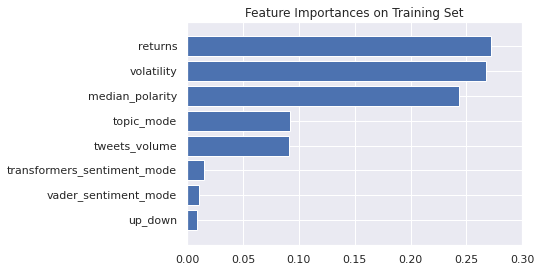

In [ ]:
feature_importance(best_pipe["clf"], X_train, y_train)

#### Prediction without Text related features

In [ ]:
train_test_split_date = "2019-09-05 00:00:00"
X_cols = ["returns", "volatility", "up_down"]
y_col = "up_down_next2min"

X_train = df_predictions_2019[X_cols].loc[df_predictions_2019.index < train_test_split_date].copy()
y_train = df_predictions_2019[y_col].loc[df_predictions_2019.index < train_test_split_date].copy()
X_test = df_predictions_2019[X_cols].loc[df_predictions_2019.index >= train_test_split_date].copy()
y_test = df_predictions_2019[y_col].loc[df_predictions_2019.index >= train_test_split_date].copy()

In [ ]:
clf = RandomForestClassifier(max_depth=optr_search.best_params_["clf__max_depth"]).fit(X_train, y_train)

Accuracy: 0.49841238825655804

F1-score: [0.42720071 0.55387556]

Weighted Average F1-score: 0.49161176000171763

              precision    recall  f1-score   support

        -1.0       0.49      0.38      0.43     10062
         1.0       0.51      0.61      0.55     10409

    accuracy                           0.50     20471
   macro avg       0.50      0.50      0.49     20471
weighted avg       0.50      0.50      0.49     20471




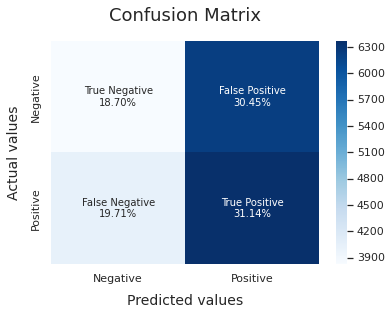

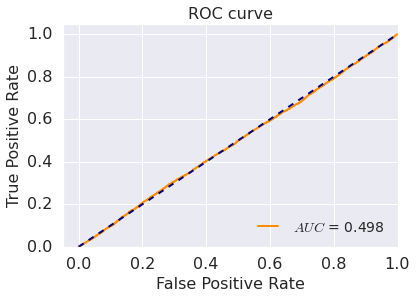

array([-1.,  1.,  1., ...,  1.,  1.,  1.])

In [ ]:
test_binary_clf(clf, X_test, y_test)

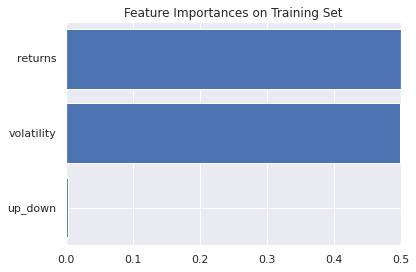

In [ ]:
feature_importance(clf, X_train, y_train)

#### Prediction with only Text related features

In [ ]:
train_test_split_date = "2019-09-05 00:00:00"
X_cols = ["tweets_volume", "median_polarity", "vader_sentiment_mode", "transformers_sentiment_mode", "topic_mode"]
y_col = "up_down_next2min"

X_train = df_predictions_2019[X_cols].loc[df_predictions_2019.index < train_test_split_date].copy()
y_train = df_predictions_2019[y_col].loc[df_predictions_2019.index < train_test_split_date].copy()
X_test = df_predictions_2019[X_cols].loc[df_predictions_2019.index >= train_test_split_date].copy()
y_test = df_predictions_2019[y_col].loc[df_predictions_2019.index >= train_test_split_date].copy()

In [ ]:
clf = RandomForestClassifier(max_depth=optr_search.best_params_["clf__max_depth"]).fit(X_train, y_train)

Accuracy: 0.5031996482829368

F1-score: [0.41672402 0.56734451]

Weighted Average F1-score: 0.49331083305339984

              precision    recall  f1-score   support

        -1.0       0.49      0.36      0.42     10062
         1.0       0.51      0.64      0.57     10409

    accuracy                           0.50     20471
   macro avg       0.50      0.50      0.49     20471
weighted avg       0.50      0.50      0.49     20471




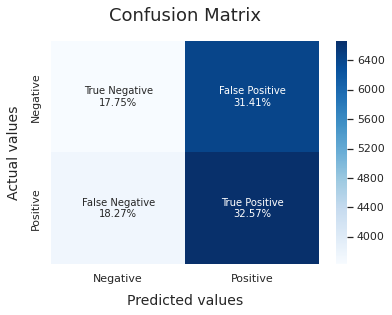

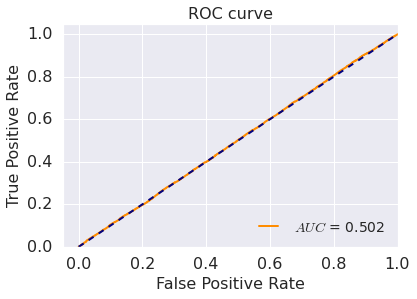

array([ 1.,  1.,  1., ..., -1.,  1., -1.])

In [ ]:
test_binary_clf(clf, X_test, y_test)

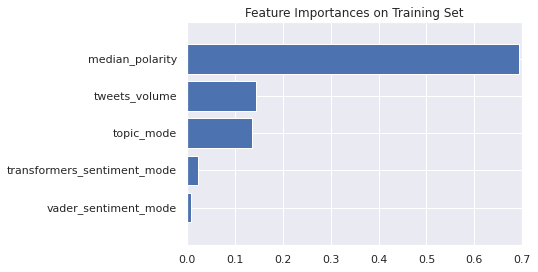

In [ ]:
feature_importance(clf, X_train, y_train)

# Returns_next2min Prediction

## Train Test Split

In [ ]:
train_test_split_date = "2019-09-05 00:00:00"
X_cols = ["tweets_volume", "median_polarity", "vader_sentiment_mode", "transformers_sentiment_mode", "topic_mode", "returns", "volatility", "up_down"]
y_col = "returns_next2min"

X_train = df_predictions_2019[X_cols].loc[df_predictions_2019.index < train_test_split_date].copy()
y_train = df_predictions_2019[y_col].loc[df_predictions_2019.index < train_test_split_date].copy()
X_test = df_predictions_2019[X_cols].loc[df_predictions_2019.index >= train_test_split_date].copy()
y_test = df_predictions_2019[y_col].loc[df_predictions_2019.index >= train_test_split_date].copy()

In [ ]:
y_train

date
2019-05-06 05:29:00   -0.033911
2019-05-06 07:26:00    0.051701
2019-05-06 07:39:00   -0.040469
2019-05-06 08:31:00   -0.000713
2019-05-06 08:48:00   -0.044076
                         ...   
2019-09-04 23:53:00   -0.016805
2019-09-04 23:54:00   -0.025779
2019-09-04 23:56:00   -0.111596
2019-09-04 23:57:00    0.025502
2019-09-04 23:58:00   -0.215456
Name: returns_next2min, Length: 107098, dtype: float64

### Linear Regression

In [ ]:
reg = LinearRegression().fit(X_train, y_train)

predictions = test_reg(reg, X_test, y_test)

R2: -0.000
MSE: 0.013
MAE: 0.068
RMSE: 0.115


# Volatility_next2min Prediction

## Train Test Split

In [ ]:
train_test_split_date = "2019-09-05 00:00:00"
X_cols = ["tweets_volume", "median_polarity", "vader_sentiment_mode", "transformers_sentiment_mode", "topic_mode", "returns", "volatility", "up_down"]
y_col = "volatility_next2min"

X_train = df_predictions_2019[X_cols].loc[df_predictions_2019.index < train_test_split_date].copy()
y_train = df_predictions_2019[y_col].loc[df_predictions_2019.index < train_test_split_date].copy()
X_test = df_predictions_2019[X_cols].loc[df_predictions_2019.index >= train_test_split_date].copy()
y_test = df_predictions_2019[y_col].loc[df_predictions_2019.index >= train_test_split_date].copy()

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
reg = LinearRegression().fit(X_train, y_train)

predictions = test_reg(reg, X_test, y_test)

R2: 0.998
MSE: 0.000
MAE: 0.001
RMSE: 0.003


### LSTM

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
# reshape input to be [samples, time steps, features]

X_train = np.reshape(np.array(X_train), (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(np.array(X_test), (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train,
          batch_size=1024,
          epochs=100,
          validation_split=0.1)

Epoch 1/100
95/95 [==============================] - 4s 8ms/step - loss: 0.6140 - accuracy: 0.0000e+00 - val_loss: 0.4982 - val_accuracy: 0.0000e+00
Epoch 2/100
95/95 [==============================] - 0s 4ms/step - loss: 0.4987 - accuracy: 0.0000e+00 - val_loss: 0.3904 - val_accuracy: 0.0000e+00
Epoch 3/100
95/95 [==============================] - 0s 4ms/step - loss: 0.4413 - accuracy: 0.0000e+00 - val_loss: 0.3481 - val_accuracy: 0.0000e+00
Epoch 4/100
95/95 [==============================] - 0s 4ms/step - loss: 0.4220 - accuracy: 0.0000e+00 - val_loss: 0.3353 - val_accuracy: 0.0000e+00
Epoch 5/100
95/95 [==============================] - 0s 4ms/step - loss: 0.4161 - accuracy: 0.0000e+00 - val_loss: 0.3319 - val_accuracy: 0.0000e+00
Epoch 6/100
95/95 [==============================] - 0s 4ms/step - loss: 0.4141 - accuracy: 0.0000e+00 - val_loss: 0.3310 - val_accuracy: 0.0000e+00
Epoch 7/100
95/95 [==============================] - 0s 4ms/step - loss: 0.4131 - accuracy: 0.0000e+00 - v

In [ ]:
predictions = test_reg(model, X_test, y_test)

R2: 0.298
MSE: 0.002
MAE: 0.045
RMSE: 0.047
